# Spotify Streaming Analysis 2024

---

## 1. Introduction

This notebook explores the **Most Streamed Spotify Songs of 2024** using data from Kaggle.  
This project aim to understand the music landscape by analyzing artist popularity, release trends, and platform-based streaming metrics like Spotify, YouTube, and TikTok.

---

### Objectives:
- Understand the **popularity and distribution** of artists and songs.
- Analyze **music release trends** by year and month.
- Explore **cross-platform relationships** among streaming metrics (Spotify, YouTube, TikTok, Shazam).
- Suggest actionable insights based on streaming behavior.

---

**Dataset Source:** [Kaggle: Most Streamed Spotify Songs 2024](https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024)

In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Dataset
df = pd.read_csv('spotify_2024.csv', encoding='latin-1')
df.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


## 2. Data Cleaning & Preparation

Let's begin by inspecting the data structure, handling missing values, correcting data types, and engineering features such as release year/month.

---

Steps:
- Handle missing values (e.g. 'Artist', platform columns)
- Convert date fields and extract release info
- Convert string numbers with commas to floats
- Fill missing numeric values with the mean

In [2]:
# Inspect Data Structure
df.info()

# Check for Missing Values
df.isnull().sum()

# Fill 'Artist' missing values with mode (most frequent)
mode_value = df['Artist'].mode().iloc[0]
df['Artist'] = df['Artist'].fillna(mode_value)

# Drop columns with too many missing values
df.drop(columns=['TIDAL Popularity', 'Soundcloud Streams', 'SiriusXM Spins'], inplace=True)

# Convert Release Date to datetime & extract Year, Month
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year
df['Release Month'] = df['Release Date'].dt.month

# Convert comma-based string numbers to float if possible
object_columns = df.select_dtypes(include='object').columns
for col in object_columns:
    try:
        df[col] = df[col].str.replace(',', '').astype(float)
    except:
        pass  # If conversion fails, keep as-is

# Fill remaining numeric NaNs with mean
for col in df.select_dtypes(include='float64'):
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

# Final Data Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

## 3. Exploratory Data Analysis

---

### 3.1 Artist Popularity 

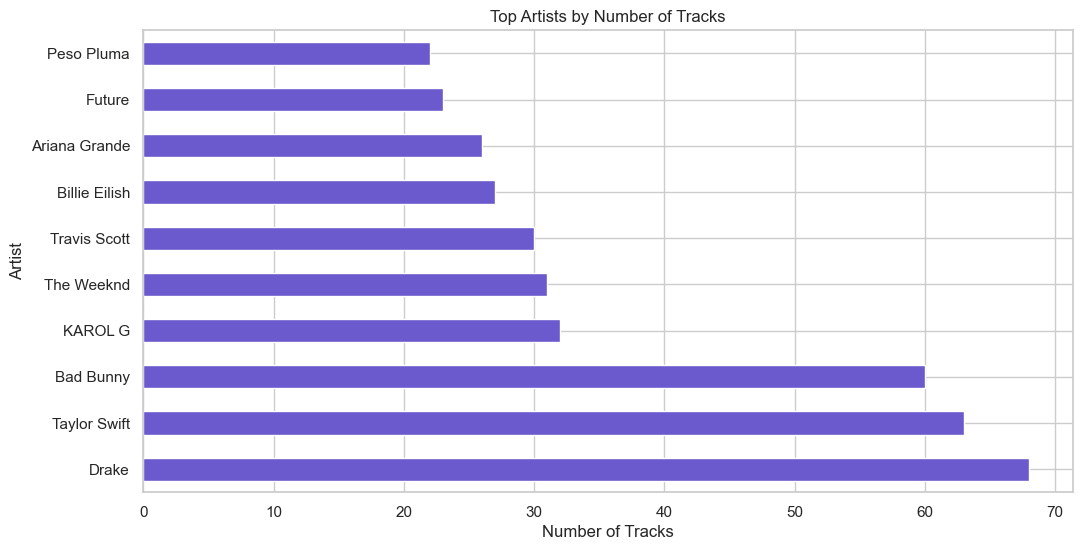

In [3]:
# Top artists by track count
top_artists = df['Artist'].value_counts().head(10)
top_artists.plot(kind='barh', color='slateblue')
plt.title('Top Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.show()

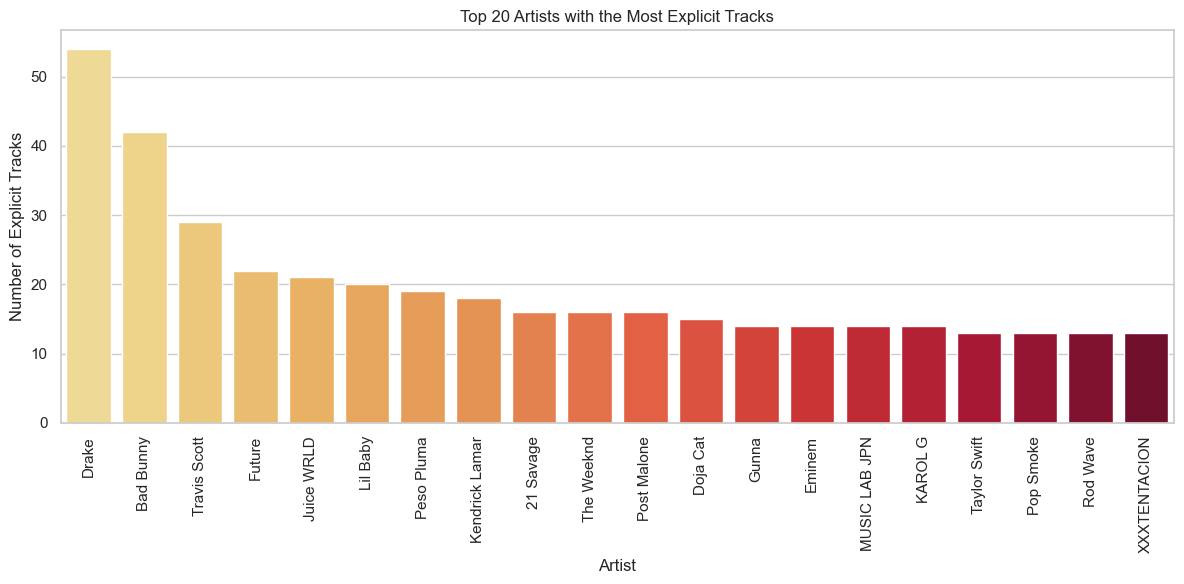

In [4]:
# Artists with most explicit tracks
explicit_tracks_by_artist = df.groupby('Artist')['Explicit Track'].sum().reset_index()
explicit_tracks_by_artist = explicit_tracks_by_artist.sort_values('Explicit Track', ascending=False).head(20)

colors = plt.cm.YlOrRd(np.linspace(0.2, 1, len(explicit_tracks_by_artist)))
sns.barplot(x='Artist', y='Explicit Track', data=explicit_tracks_by_artist, palette=colors)
plt.title('Top 20 Artists with the Most Explicit Tracks')
plt.xlabel('Artist')
plt.ylabel('Number of Explicit Tracks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.2 Explicit Content & Streams

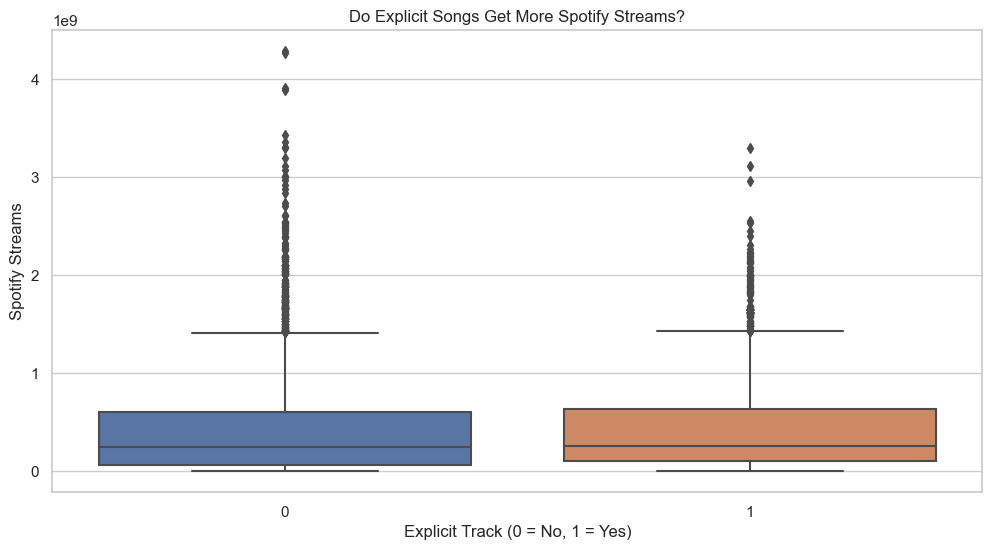

In [5]:
# Explicit songs vs streams
sns.boxplot(x='Explicit Track', y='Spotify Streams', data=df)
plt.title('Do Explicit Songs Get More Spotify Streams?')
plt.xlabel('Explicit Track (0 = No, 1 = Yes)')
plt.ylabel('Spotify Streams')
plt.show()

**Box Plot Breakdown: Spotify Streams by Explicit Label**

This box plot compares streaming distributions across explicit (`1`) and non-explicit (`0`) tracks.

---

**Box Elements:**

- **Median line**: Middle value of the data
- **Box edges**: 25th and 75th percentiles (IQR)
- **Whiskers**: Extend to 1.5× the IQR
- **Dots**: Outliers represent extremely high or low stream counts

---

**Insights from This Plot:**

- **Median Streams Are Similar**:  
  Both groups show similar median values, meaning there's no strong difference in typical Spotify streams between explicit and non-explicit songs.

- **Spread (IQR) Is Comparable**:  
  The interquartile range is nearly equal for both categories, indicating similar variability among the middle 50% of songs.

- **Non-Explicit Songs Have Higher Outliers**:  
  Extremely high-streamed tracks (e.g., over 4 billion) are more often non-explicit, suggesting that the biggest global hits are usually clean.

- **Skewness**:  
  Both groups show positive skew especially non-explicit songs due to a few tracks dominating in stream counts.

---

**Interpretation:**  
This plot shows no strong evidence that explicit songs perform better in terms of average or median streams. Both explicit and non-explicit tracks have similar distributions, but non-explicit songs tend to dominate the ultra-high stream counts. Therefore, being explicit does not appear to give a consistent streaming advantage.


### 3.3 Release Trends

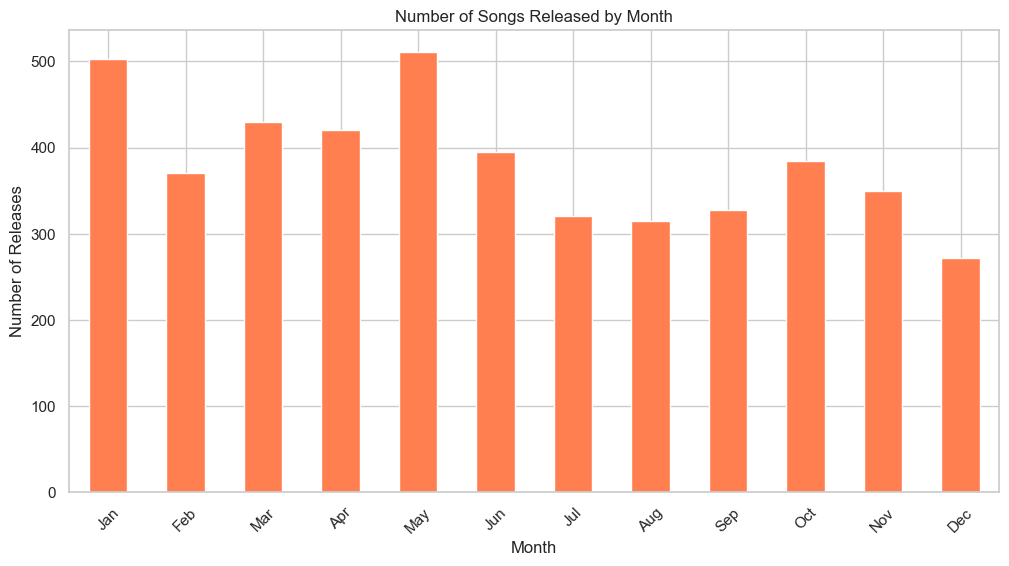

In [6]:
# Songs released by month
df['Release Month'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.title('Number of Songs Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.show()

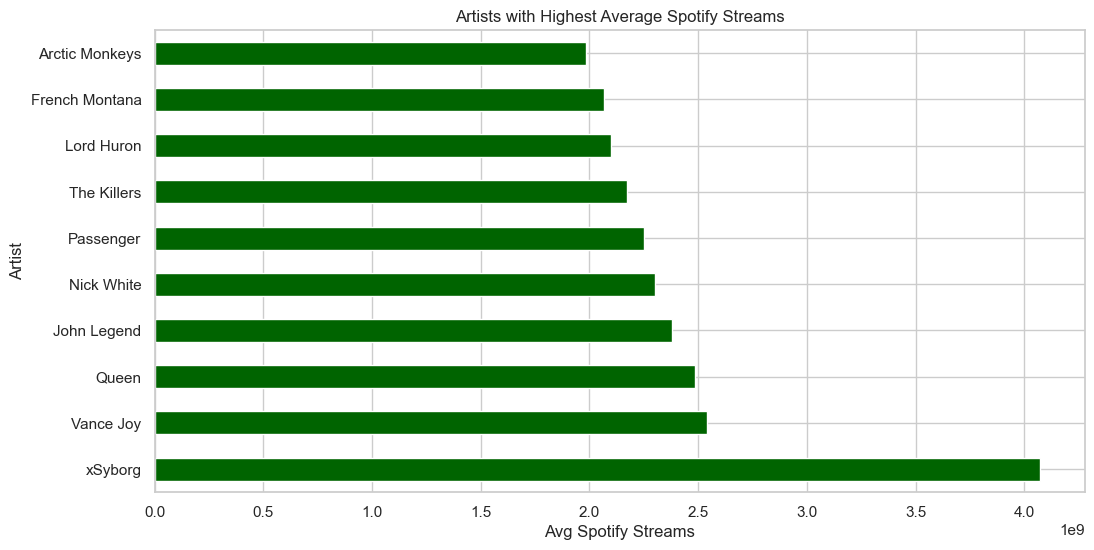

In [7]:
# Top artists by average streams
top_avg_streams = df.groupby('Artist')['Spotify Streams'].mean().sort_values(ascending=False).head(10)
top_avg_streams.plot(kind='barh', color='darkgreen')
plt.title('Artists with Highest Average Spotify Streams')
plt.xlabel('Avg Spotify Streams')
plt.ylabel('Artist')
plt.show()

### 3.4 Cross-Platform Relationships

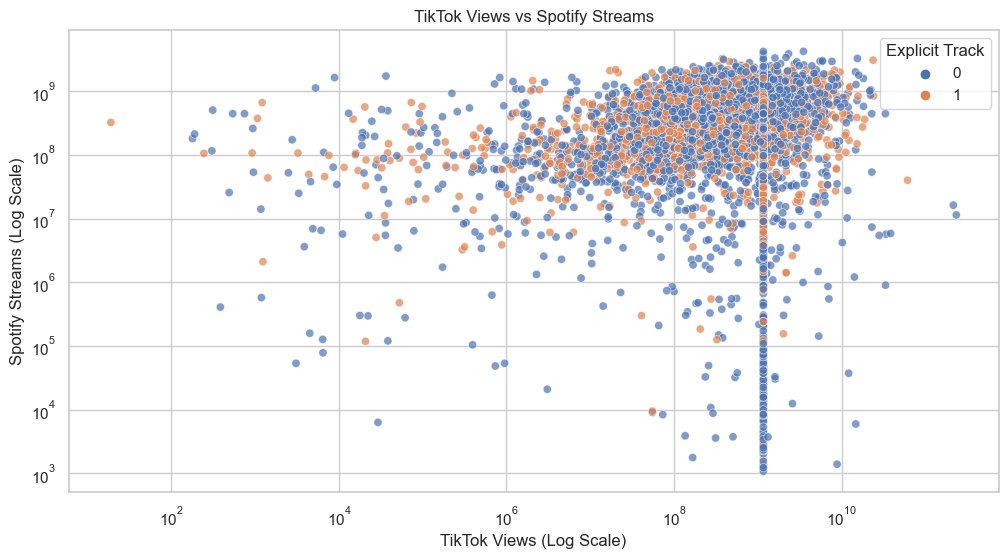

In [8]:
# TikTok views vs Spotify streams for explicit track
sns.scatterplot(data=df, x='TikTok Views', y='Spotify Streams', hue='Explicit Track', alpha=0.7)
plt.title('TikTok Views vs Spotify Streams')
plt.xlabel('TikTok Views (Log Scale)')
plt.ylabel('Spotify Streams (Log Scale)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend(title='Explicit Track')
plt.show()

**What This Scatter Plot Shows**

---

- **Axes (Log-Scaled):**
  - **X-axis:** TikTok Views (from 10² to 10¹⁰)
  - **Y-axis:** Spotify Streams (from 10³ to 10⁹)
- **Each Dot:** A music track
  - **Blue = Non-explicit**
  - **Orange = Explicit**
  
---

**Interpretation**
- **Positive Correlation:** Tracks with high TikTok views tend to also have high Spotify streams.
- **Viral Cluster:** There’s a visible concentration in the top-right as they are the viral songs performing strongly on both platforms.
- **Explicit Tracks Thrive Too:** Orange dots are present throughout, including among the top performers, showing that explicit content doesn’t limit streaming success.

---

**Insight**:

**TikTok virality strongly translates into Spotify popularity.** This underscores TikTok’s influence as a music discovery engine, even for tracks with explicit content.

## Classification Modeling
---

### 4.1 Features Definition

In [9]:
# Define features used to predict whether a song is explicit
features = ['TikTok Views', 'YouTube Views', 'TikTok Likes', 'YouTube Likes',
            'Shazam Counts', 'Pandora Streams', 'Release Year', 'Release Month']

# X = predictors, y = target label (Explicit: 1 = yes, 0 = no)
X = df[features]
y = df['Explicit Track']  

### 4.2 Train-Test Split & Scaling

Standardizing ensures that features with large magnitudes (e.g. views) don’t dominate the model.

In [10]:
# Split dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to normalize their scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.3 Model 1: Balanced Random Forest

In [11]:
# Use class_weight='balanced' to compensate for class imbalance
clf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf_balanced.fit(X_train_scaled, y_train)
y_pred_balanced = clf_balanced.predict(X_test_scaled)

In [12]:
# Evaluate Random Forest
print("Random Forest (Balanced) Report:")
print(classification_report(y_test, y_pred_balanced))

Random Forest (Balanced) Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.76       575
           1       0.58      0.39      0.47       345

    accuracy                           0.67       920
   macro avg       0.64      0.61      0.61       920
weighted avg       0.65      0.67      0.65       920



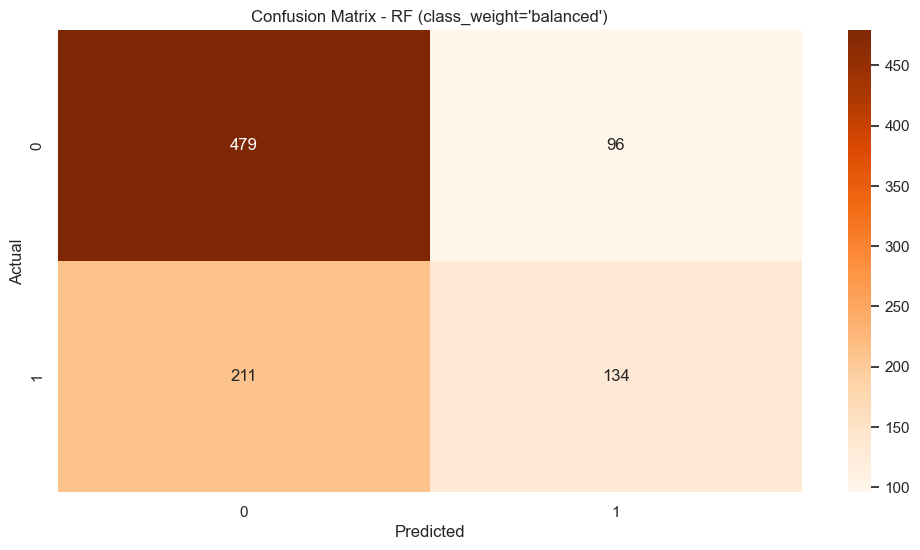

In [13]:
# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF (class_weight='balanced')")
plt.show()

**Interpretation**:

- **Accuracy = 67%**, similar to original model
- **Recall (class 1) = 0.39** shows that it still misses many explicit tracks
- This model prioritizes avoiding false positives

### 4.4 Model 2: Balanced Logistic Regression 

In [14]:
# Train a logistic regression model for interpretability
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.70      0.39      0.50       575
           1       0.42      0.72      0.53       345

    accuracy                           0.51       920
   macro avg       0.56      0.56      0.51       920
weighted avg       0.59      0.51      0.51       920



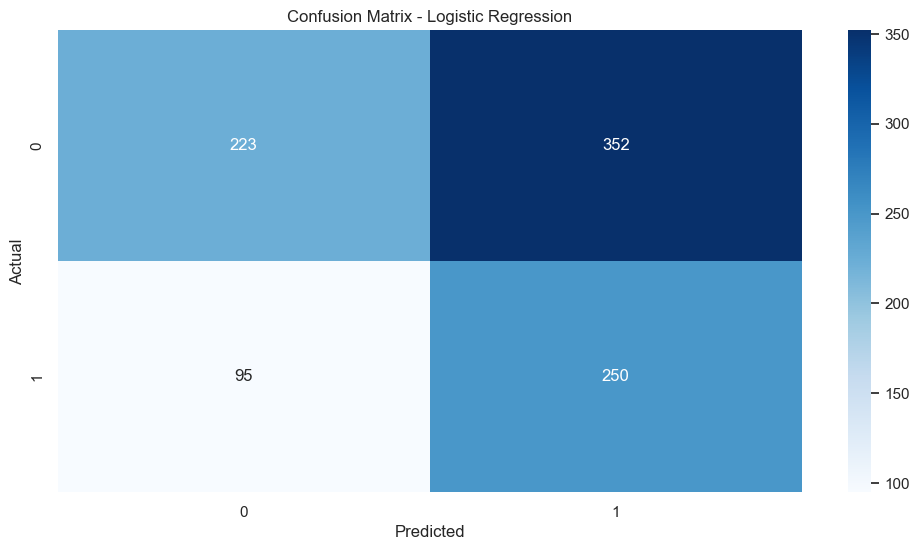

In [15]:
# Evaluate logistic regression
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

**Interpretation**:

- **Accuracy = 51%** reflects the model’s tendency to favor identifying explicit content.
- **Recall (class 1) = 0.72** shows that it captures most explicit tracks.
- This comes with a trade-off: many clean (non-explicit) songs are predicted as explicit, resulting in lower precision and accuracy.

### 4.5 Coefficient Analysis 

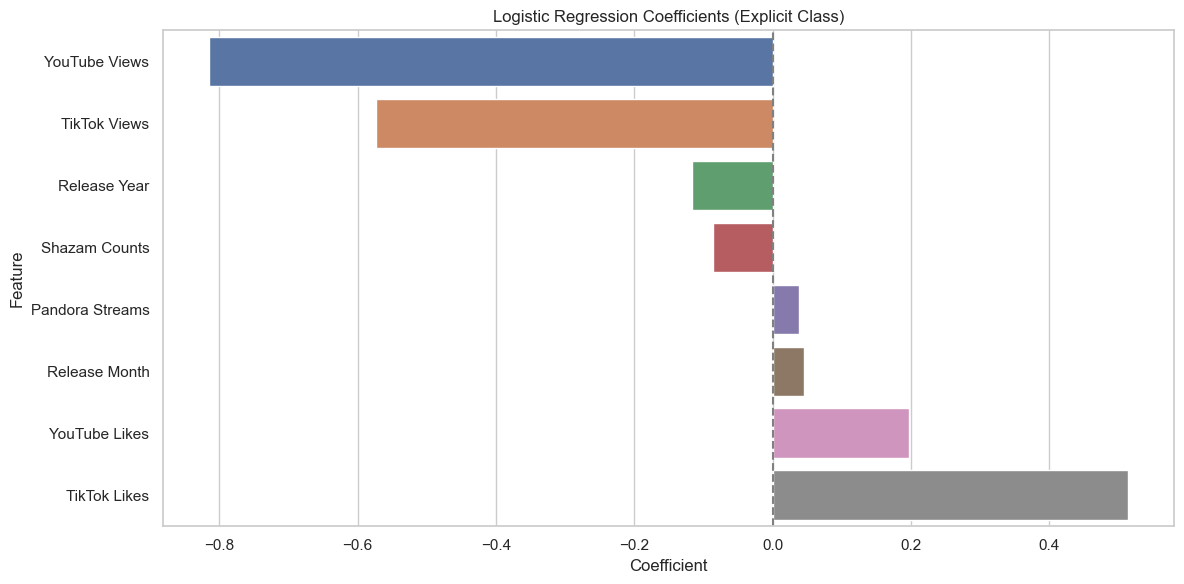

In [16]:
# Create a DataFrame of feature coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient')

# Visualize feature influence
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Logistic Regression Coefficients (Explicit Class)")
plt.tight_layout()
plt.show()

**Interpretation**:

- **Positive coefficients** (e.g. TikTok Likes, YouTube Likes) → increase odds of a track being explicit
- **Negative coefficients** (e.g. YouTube Views, TikTok Views, Release Year) → reduce odds of being explicit
- Likes (engagement) seem more indicative of explicit content than views (visibility)

## 5. ROC Curve Analysis
---

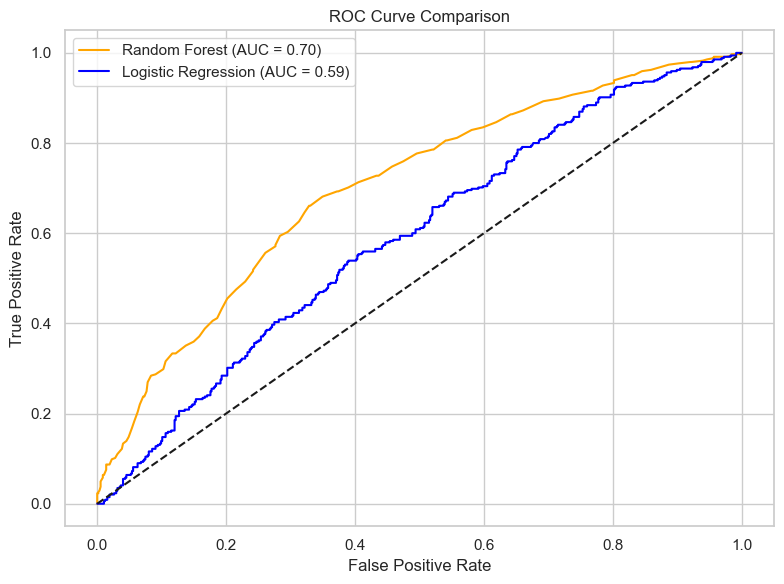

In [17]:
# Get predicted probabilities for class 1
y_prob_rf = clf_balanced.predict_proba(X_test_scaled)[:, 1]
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

# AUC scores
auc_rf = auc(fpr_rf, tpr_rf)
auc_log = auc(fpr_log, tpr_log)

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='orange')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal = random guess

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ROC Curve Analysis

To evaluate model performance across all classification thresholds, we plotted the **ROC (Receiver Operating Characteristic)** curve for both models:

- **X-axis**: False Positive Rate (FPR)
- **Y-axis**: True Positive Rate (TPR) or Recall
- **Diagonal line**: Random guessing (AUC = 0.5)
- **AUC (Area Under Curve)**: Measures the model's ability to distinguish between classes

---

### Results

| Model                    | AUC Score | Interpretation                        |
|--------------------------|-----------|----------------------------------------|
|Balanced Random Forest | 0.70 | Good ability to separate explicit vs non-explicit |
|Logistic Regression    | 0.59 | Slightly lower but still better than random guessing |

- **Random Forest** ROC curve likely rises more steadily, indicating reliable performance across thresholds.
- **Logistic Regression** may spike early (high recall) but drop due to false positives.

---

### Takeaways

- **Higher AUC** = better overall model
- ROC is **threshold-independent**, helping visualize how models perform beyond fixed 0.5 cut-off
- Logistic Regression favors **recall (TPR)**, while Random Forest balances precision and recall better